# Module version used

- torch 1.4
- numpy 1.18.1
- CPython 3.6.9
- IPython 7.10.2
- numpy     1.17.4
- PIL.Image 6.2.1
- pandas    0.25.3

- Runs on CPU or GPU (if available)

# Convolutional Autoencoder with Nearest-neighbor Interpolation

A convolutional autoencoder using nearest neighbor upscaling layers that compresses 768-pixel MNIST images down to a 7x7x8 (392 pixel) representation.

## Imports

In [2]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [3]:
##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Hyperparameters
random_seed = 123
learning_rate = 0.05
num_epochs = 10
batch_size = 128


##########################
### MNIST DATASET
##########################
serverAvailable = "no"
if serverAvailable == "yes":
    datapath = "../database/"
else:
    datapath = '../../../../MEGA/DatabaseLocal/'

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root=datapath, 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root=datapath, 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Device: cuda:0
Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


## Model

In [4]:
##########################
### MODEL
##########################

class ConvolutionalAutoencoder(torch.nn.Module):

    def __init__(self):
        super(ConvolutionalAutoencoder, self).__init__()
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2
        
        ### ENCODER
        
        # 28x28x1 => 28x28x4
        self.conv_1 = torch.nn.Conv2d(in_channels=1,
                                      out_channels=4,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      # (1(28-1) - 28 + 3) / 2 = 1
                                      padding=1)
        # 28x28x4 => 14x14x4
        self.pool_1 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         # (2(14-1) - 28 + 2) / 2 = 0
                                         padding=0)                                       
        # 14x14x4 => 14x14x8
        self.conv_2 = torch.nn.Conv2d(in_channels=4,
                                      out_channels=8,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      # (1(14-1) - 14 + 3) / 2 = 1
                                      padding=1)                 
        # 14x14x8 => 7x7x8                             
        self.pool_2 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         # (2(7-1) - 14 + 2) / 2 = 0
                                         padding=0)
        
        ### DECODER
                                         
        # 7x7x8 => 14x14x8               
        # Unpool

        # 14x14x8 => 14x14x8
        self.conv_3 = torch.nn.Conv2d(in_channels=8,
                                      out_channels=4,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      # (1(14-1) - 14 + 3) / 2 = 1
                                      padding=1)
        # 14x14x4 => 28x28x4                            
        # Unpool
        
        # 28x28x4 => 28x28x1
        self.conv_4 = torch.nn.Conv2d(in_channels=4,
                                      out_channels=1,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      # (1(28-1) - 28 + 3) / 2 = 1
                                      padding=1)
        
    def forward(self, x):
        
        ### ENCODER
        x = self.conv_1(x)
        x = F.leaky_relu(x)
        x = self.pool_1(x)
        x = self.conv_2(x)
        x = F.leaky_relu(x)
        x = self.pool_2(x)
        
        ### DECODER
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv_3(x)
        x = F.leaky_relu(x)
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv_4(x)
        logits = F.leaky_relu(x)
        probas = torch.sigmoid(logits)
        return logits, probas

    
torch.manual_seed(random_seed)
model = ConvolutionalAutoencoder()
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [5]:
print(model)

ConvolutionalAutoencoder(
  (conv_1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool_1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool_2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_4): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


## Training

In [6]:
start_time = time.time()
for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        # don't need labels, only the images (features)
        features = features.to(device)

        ### FORWARD AND BACK PROP
        logits, decoded = model(features)
        cost = F.binary_cross_entropy_with_logits(logits, features)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
            
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 000/469 | Cost: 0.7008
Epoch: 001/010 | Batch 050/469 | Cost: 0.1793
Epoch: 001/010 | Batch 100/469 | Cost: 0.1380
Epoch: 001/010 | Batch 150/469 | Cost: 0.1249
Epoch: 001/010 | Batch 200/469 | Cost: 0.1191
Epoch: 001/010 | Batch 250/469 | Cost: 0.1112
Epoch: 001/010 | Batch 300/469 | Cost: 0.1089
Epoch: 001/010 | Batch 350/469 | Cost: 0.1070
Epoch: 001/010 | Batch 400/469 | Cost: 0.1052
Epoch: 001/010 | Batch 450/469 | Cost: 0.0999
Time elapsed: 0.07 min
Epoch: 002/010 | Batch 000/469 | Cost: 0.0995
Epoch: 002/010 | Batch 050/469 | Cost: 0.1023
Epoch: 002/010 | Batch 100/469 | Cost: 0.1018
Epoch: 002/010 | Batch 150/469 | Cost: 0.0972
Epoch: 002/010 | Batch 200/469 | Cost: 0.0977
Epoch: 002/010 | Batch 250/469 | Cost: 0.0994
Epoch: 002/010 | Batch 300/469 | Cost: 0.0970
Epoch: 002/010 | Batch 350/469 | Cost: 0.0981
Epoch: 002/010 | Batch 400/469 | Cost: 0.0966
Epoch: 002/010 | Batch 450/469 | Cost: 0.0979
Time elapsed: 0.14 min
Epoch: 003/010 | Batch 000/469 | C

## Evaluation

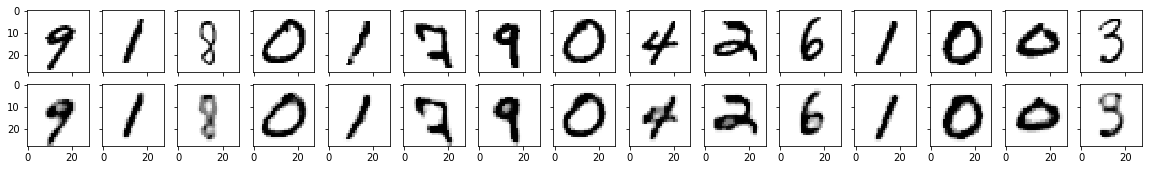

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

##########################
### VISUALIZATION
##########################

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')